# CodeBERTScore Analysis (updated schema)

Analyze similarity results with the new CSV format that includes `prompt_level`, `Processor`, and normalized `Model` values (phi4, qw32, gpt5).

In [26]:
# Label mappings for plotting
MODEL_LABELS = {
    "gpt-5": "G5",
    "gpt-4o": "G4o",
    "gpt-4o-mini": "G4o-m",
    "phi4": "Phi4",
    "qwen32": "Qw32B",
    "qwen14": "Qw14B",
    "codestral": "Co22B",
    "gemma3": "Ge3",
}

PROCESSOR_LABELS = { "dp": "DP",
                    "mc": "MC",  
                    "sg": "ArdSG",
                    "psg": "PySG-CPU", 
                    "tpusg": "PySG-TPU",}
PROMPT_TYPE_LABELS = {
    'abla-l1': 'Prompt L1',
    'abla-1p': 'Prompt L1-P',
    'abla-2p': 'Prompt L2-P',
    'abla-l2': 'Prompt L2',
    'original': 'Prompt Original'
    
}
MODEL_ORDER_PREF = list(MODEL_LABELS.keys())
PROCESSOR_ORDER_PREF = list(PROCESSOR_LABELS.keys())
TYPE_ORDER_PREF = list(PROMPT_TYPE_LABELS.keys())

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np 

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

BOX_KWARGS = {
    "showmeans": True,
    "showfliers": False,
    "meanprops": {"marker": "x", "markeredgecolor": "black", "markersize": 7, "linestyle": "none"},
    "medianprops": {"color": "black", "linewidth": 2},
    "whiskerprops": {"color": "black", "linewidth": 1.5},
    "capprops": {"color": "black", "linewidth": 1.5},
    "flierprops": {"marker": "o", "markerfacecolor": "gray", "markeredgecolor": "gray", "markersize": 4, "alpha": 0.8},
    # Keep palette facecolors; only style edges.
    "boxprops": {"edgecolor": "black", "linewidth": 1.5},
}
COLOR_PALETTE = sns.color_palette("Set2")

SCRIPT_DIR = Path.cwd()
PROJECT_ROOT = SCRIPT_DIR.parent.parent if SCRIPT_DIR.name == "analyser-results" else SCRIPT_DIR
DATASETS = {
    "psg": PROJECT_ROOT / "codebertscore-similarity/analyser-results/similarity_results_psg.csv",
    "sg": PROJECT_ROOT / "codebertscore-similarity/analyser-results/similarity_results_sg.csv",
    "tpusg": PROJECT_ROOT / "codebertscore-similarity/analyser-results/similarity_results_tpusg.csv",
}
required_cols = ["Candidate_ID", "Model", "Prompt_level", "Precision", "Recall", "F1", "F3", "Processor"]

## Load Data

In [28]:
frames = []
missing = []
for proc, path in DATASETS.items():
    if not path.exists():
        missing.append(f"{proc}: {path}")
        continue
    df_part = pd.read_csv(path)
    df_part["Processor"] = proc  # enforce processor label
    frames.append(df_part)

if missing:
    print("Missing datasets:")
    for m in missing:
        print(m)

df = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame(columns=required_cols)
df.head()

,Candidate_ID,Model,Precision,Recall,F1,F3,Processor,Prompt_level
0,langfuse_export/2025/07.30_abla-og-phi4/export...,phi4,0.874021,0.820260,0.846288,0.825337,psg,original
1,langfuse_export/2025/07.30_abla-og-phi4/export...,phi4,0.891725,0.831951,0.860802,0.837565,psg,original
2,langfuse_export/2025/07.30_abla-og-phi4/export...,phi4,0.885038,0.815476,0.848834,0.821936,psg,original
3,langfuse_export/2025/07.30_abla-og-phi4/export...,phi4,0.897614,0.819714,0.856897,0.826891,psg,original
4,langfuse_export/2025/07.30_abla-og-phi4/export...,phi4,0.874875,0.789581,0.830043,0.797354,psg,original


## Clean and normalize columns

In [29]:
def parse_model_fields(raw_model):
    text = str(raw_model)
    if "_" in text:
        _, text = text.split("_", 1)
        
    levels = ["abla-l1", "abla-l2", "abla-1p", "abla-2p"]
    prompt_level = next((lvl for lvl in levels if lvl in text), "original")
    # prompt_level = "abla-l1" if "abla-l1" in text else "abla-l2" if "abla-l2" in text else "original"
    # Normalize model names: gpt-5 -> gpt5, qwen32 -> qw32
    if "gpt" in text.lower():
        base_model = "gpt5"
    elif "qwen" in text.lower() or "qw" in text.lower():
        base_model = "qw32"
    elif "phi" in text.lower():
        base_model = "phi4"
    else:
        base_model = text.split("-")[0]
    return base_model, prompt_level

valid_prompts = {"abla-l1", "abla-l2", "original", "abla-1p", "abla-2p"}

def normalize_row(row):
    base_model, inferred_prompt = parse_model_fields(row.get("Model", ""))
    raw_prompt = row.get("Prompt_level", "")
    prompt = raw_prompt if str(raw_prompt) in valid_prompts else inferred_prompt
    return pd.Series({"Model": base_model, "Prompt_level": prompt})

if df.empty:
    print("No data loaded; check dataset paths.")
else:
    normalized = df.apply(normalize_row, axis=1)
    df["Model"] = normalized["Model"]
    df["Prompt_level"] = normalized["Prompt_level"]
    df = df[required_cols]
df.head()

,Candidate_ID,Model,Prompt_level,Precision,Recall,F1,F3,Processor
0,langfuse_export/2025/07.30_abla-og-phi4/export...,phi4,original,0.874021,0.820260,0.846288,0.825337,psg
1,langfuse_export/2025/07.30_abla-og-phi4/export...,phi4,original,0.891725,0.831951,0.860802,0.837565,psg
2,langfuse_export/2025/07.30_abla-og-phi4/export...,phi4,original,0.885038,0.815476,0.848834,0.821936,psg
3,langfuse_export/2025/07.30_abla-og-phi4/export...,phi4,original,0.897614,0.819714,0.856897,0.826891,psg
4,langfuse_export/2025/07.30_abla-og-phi4/export...,phi4,original,0.874875,0.789581,0.830043,0.797354,psg


## Export Processed Data for Plotting

Save the cleaned and normalized dataset for easy reuse in plotting scripts. This file contains all metrics ready for visualization without needing to reprocess the raw CSVs.

In [30]:
# Save the processed data for direct use in plotting
OUTPUT_FILE = SCRIPT_DIR / "processed_similarity_data.csv"

if not df.empty:
    # Save with all required columns in a consistent order
    df_export = df[required_cols].copy()
    df_export.to_csv(OUTPUT_FILE, index=False)
    print(f"✔ Saved processed data to: {OUTPUT_FILE}")
    print(f"  Total rows: {len(df_export)}")
    print(f"  Columns: {', '.join(df_export.columns)}")
    print(f"\n  Data summary:")
    print(f"    Models: {sorted(df_export['Model'].unique())}")
    print(f"    Prompt levels: {sorted(df_export['Prompt_level'].unique())}")
    print(f"    Processors: {sorted(df_export['Processor'].unique())}")
    print(f"\n  Rows per group:")
    print(df_export.groupby(['Prompt_level', 'Model', 'Processor']).size().to_string())
else:
    print("⚠ No data to export. Check that CSV files are loaded correctly.")

✔ Saved processed data to: /home/han/Projects/benchmark-tinyml_llm-2026/codebertscore-similarity/analyser-results/processed_similarity_data.csv
  Total rows: 636
  Columns: Candidate_ID, Model, Prompt_level, Precision, Recall, F1, F3, Processor

  Data summary:
    Models: ['gpt5', 'phi4', 'qw32']
    Prompt levels: ['abla-1p', 'abla-2p', 'abla-l1', 'abla-l2', 'original']
    Processors: ['psg', 'sg', 'tpusg']

  Rows per group:
Prompt_level  Model  Processor
abla-1p       qw32   psg          12
abla-2p       phi4   psg          17
                     tpusg        48
              qw32   psg          30
                     tpusg        30
abla-l1       gpt5   psg          30
                     sg            3
                     tpusg        30
              phi4   psg          15
                     tpusg        12
              qw32   psg          24
                     tpusg        24
abla-l2       gpt5   psg          30
                     sg           21
                  

In [31]:
# Quick load example - use this to reload processed data in future sessions
# Uncomment and run this cell instead of the data loading/processing cells above:
#
# df = pd.read_csv(SCRIPT_DIR / "processed_similarity_data.csv")
# print(f"Loaded {len(df)} rows from processed_similarity_data.csv")
# df.head()

print("💡 Tip: To use the processed data in a new notebook or script:")
print("   df = pd.read_csv('processed_similarity_data.csv')")
print("   # All columns are ready: Model, prompt_level, Processor, Precision, Recall, F1, F3")

💡 Tip: To use the processed data in a new notebook or script:
   df = pd.read_csv('processed_similarity_data.csv')
   # All columns are ready: Model, prompt_level, Processor, Precision, Recall, F1, F3


## Export Box Plot Statistics

Compute and export aggregated statistics (mean, median, quartiles, min, max, outliers) for each combination of Model × prompt_level × Processor. This data is ready for direct plotting without recalculation.

In [32]:
# Compute box plot statistics for each metric and group
metrics_to_analyze = ['Precision', 'Recall', 'F1', 'F3']
grouping_cols = ['Model', 'Prompt_level', 'Processor']

stats_list = []

for metric in metrics_to_analyze:
    # Group and compute all statistics
    grouped = df.groupby(grouping_cols)[metric]
    
    # Basic statistics
    stats_df = grouped.agg([
        ('count', 'count'),
        ('mean', 'mean'),
        ('std', 'std'),
        ('min', 'min'),
        ('Q1', lambda x: x.quantile(0.25)),
        ('median', 'median'),
        ('Q3', lambda x: x.quantile(0.75)),
        ('max', 'max')
    ]).reset_index()
    
    # Add derived statistics
    stats_df['IQR'] = stats_df['Q3'] - stats_df['Q1']
    stats_df['lower_whisker'] = stats_df.apply(
        lambda row: max(row['min'], row['Q1'] - 1.5 * row['IQR']), axis=1
    )
    stats_df['upper_whisker'] = stats_df.apply(
        lambda row: min(row['max'], row['Q3'] + 1.5 * row['IQR']), axis=1
    )
    
    # Count outliers for each group
    def count_outliers(group, lower, upper):
        return ((group < lower) | (group > upper)).sum()
    
    outlier_counts = []
    for idx, row in stats_df.iterrows():
        mask = (df['Model'] == row['Model']) & \
               (df['Prompt_level'] == row['Prompt_level']) & \
               (df['Processor'] == row['Processor'])
        group_data = df.loc[mask, metric]
        outlier_count = count_outliers(group_data, row['lower_whisker'], row['upper_whisker'])
        outlier_counts.append(outlier_count)
    
    stats_df['outlier_count'] = outlier_counts
    stats_df['metric'] = metric
    
    stats_list.append(stats_df)

# Combine all metrics
boxplot_stats = pd.concat(stats_list, ignore_index=True)

# Reorder columns for better readability
col_order = ['metric', 'Model', 'Prompt_level', 'Processor', 'count', 
             'mean', 'median', 'std', 'min', 'Q1', 'Q3', 'max', 
             'IQR', 'lower_whisker', 'upper_whisker', 'outlier_count']
boxplot_stats = boxplot_stats[col_order]

print(f"✔ Computed box plot statistics for {len(boxplot_stats)} groups")
print(f"  Metrics: {metrics_to_analyze}")
print(f"  Groups: {len(boxplot_stats) // len(metrics_to_analyze)} combinations")
boxplot_stats.head(12)

✔ Computed box plot statistics for 104 groups
  Metrics: ['Precision', 'Recall', 'F1', 'F3']
  Groups: 26 combinations


,metric,Model,Prompt_level,Processor,count,mean,median,std,min,Q1,Q3,max,IQR,lower_whisker,upper_whisker,outlier_count
0,Precision,gpt5,abla-l1,psg,30,0.826513,0.827300,0.010443,0.807427,0.818332,0.834930,0.847317,0.016598,0.807427,0.847317,0
1,Precision,gpt5,abla-l1,sg,3,0.831381,0.836078,0.013932,0.815708,0.825893,0.839218,0.842357,0.013324,0.815708,0.842357,0
2,Precision,gpt5,abla-l1,tpusg,30,0.810734,0.816312,0.014359,0.783676,0.797119,0.819960,0.834903,0.022841,0.783676,0.834903,0
3,Precision,gpt5,abla-l2,psg,30,0.798674,0.799578,0.013972,0.776612,0.788429,0.806920,0.821753,0.018491,0.776612,0.821753,0
4,Precision,gpt5,abla-l2,sg,21,0.819970,0.816256,0.009968,0.807338,0.813042,0.824660,0.839926,0.011618,0.807338,0.839926,0
5,Precision,gpt5,abla-l2,tpusg,30,0.810785,0.811928,0.012256,0.790660,0.800760,0.819089,0.833060,0.018329,0.790660,0.833060,0
6,Precision,gpt5,original,psg,29,0.787690,0.786631,0.008190,0.773992,0.783122,0.793384,0.803599,0.010262,0.773992,0.803599,0
7,Precision,gpt5,original,sg,30,0.832219,0.832035,0.006876,0.820863,0.828413,0.835524,0.853561,0.007111,0.820863,0.846190,1
8,Precision,gpt5,original,tpusg,27,0.812258,0.813080,0.009295,0.789063,0.807669,0.819269,0.826213,0.011599,0.790270,0.826213,2
9,Precision,phi4,abla-2p,psg,17,0.894301,0.894809,0.002417,0.890756,0.893481,0.894951,0.899417,0.001470,0.891275,0.897156,4


In [33]:
# Export box plot statistics to CSV
BOXPLOT_STATS_FILE = SCRIPT_DIR / "boxplot_statistics.csv"

boxplot_stats.to_csv(BOXPLOT_STATS_FILE, index=False, float_format='%.6f')

print(f"✔ Saved box plot statistics to: {BOXPLOT_STATS_FILE}")
print(f"  Total rows: {len(boxplot_stats)}")
print(f"  Columns: {len(boxplot_stats.columns)}")
print(f"\n  Statistics per row:")
print(f"    - count, mean, median, std")
print(f"    - min, Q1, Q3, max")
print(f"    - IQR, lower_whisker, upper_whisker")
print(f"    - outlier_count")
print(f"\n  Breakdown by metric:")
for metric in metrics_to_analyze:
    count = len(boxplot_stats[boxplot_stats['metric'] == metric])
    print(f"    {metric}: {count} groups")

✔ Saved box plot statistics to: /home/han/Projects/benchmark-tinyml_llm-2026/codebertscore-similarity/analyser-results/boxplot_statistics.csv
  Total rows: 104
  Columns: 16

  Statistics per row:
    - count, mean, median, std
    - min, Q1, Q3, max
    - IQR, lower_whisker, upper_whisker
    - outlier_count

  Breakdown by metric:
    Precision: 26 groups
    Recall: 26 groups
    F1: 26 groups
    F3: 26 groups


In [34]:
# View a sample of the exported statistics
print("📊 Sample of box plot statistics:")
print("\nF1 scores for 'original' prompt level:\n")
sample = boxplot_stats[
    (boxplot_stats['metric'] == 'F1') & 
    (boxplot_stats['Prompt_level'] == 'original')
].sort_values(['Processor', 'Model'])
print(sample[['Model', 'Processor', 'count', 'mean', 'median', 'Q1', 'Q3', 'min', 'max']].to_string(index=False))

print("\n" + "="*70)
print("💡 Usage in plotting scripts:")
print("="*70)
print("""
# Load the statistics
stats = pd.read_csv('boxplot_statistics.csv')

# Filter for specific metric and group
f1_stats = stats[stats['metric'] == 'F1']

# Access values for plotting
for _, row in f1_stats.iterrows():
    model = row['Model']
    prompt = row['Prompt_level']
    processor = row['Processor']
    
    # Box plot elements ready to use:
    # - Box: Q1 to Q3
    # - Median line: row['median']
    # - Whiskers: row['lower_whisker'] to row['upper_whisker']
    # - Mean marker: row['mean']
    # - Range: row['min'] to row['max']
""")

📊 Sample of box plot statistics:

F1 scores for 'original' prompt level:

Model Processor  count     mean   median       Q1       Q3      min      max
 gpt5       psg     29 0.826552 0.826654 0.823393 0.829045 0.819426 0.835022
 phi4       psg     18 0.822144 0.847561 0.824086 0.861532 0.615672 0.880539
 qw32       psg     18 0.858439 0.861494 0.858215 0.864545 0.833282 0.867286
 gpt5        sg     30 0.850397 0.850387 0.847470 0.852943 0.841328 0.861659
 gpt5     tpusg     27 0.841154 0.840992 0.837818 0.845141 0.828340 0.849622
 phi4     tpusg     30 0.869025 0.868509 0.863262 0.874050 0.847821 0.883387
 qw32     tpusg     30 0.864707 0.864468 0.859880 0.869572 0.848805 0.877104

💡 Usage in plotting scripts:

# Load the statistics
stats = pd.read_csv('boxplot_statistics.csv')

# Filter for specific metric and group
f1_stats = stats[stats['metric'] == 'F1']

# Access values for plotting
for _, row in f1_stats.iterrows():
    model = row['Model']
    prompt = row['Prompt_level']
    pr

In [35]:
# DEBUG: Check prompt_level values before normalization
print("=== BEFORE Normalization ===")
frames_debug = []
for proc, path in DATASETS.items():
    if not path.exists():
        continue
    df_part = pd.read_csv(path)
    df_part["Processor"] = proc
    frames_debug.append(df_part)
df_before = pd.concat(frames_debug, ignore_index=True)
print(f"Unique prompt_level values: {df_before['Prompt_level'].unique()}")
print(f"Value counts:\n{df_before['Prompt_level'].value_counts()}")

print("\n=== AFTER Normalization ===")
print(f"Unique prompt_level values: {df['Prompt_level'].unique()}")
print(f"Value counts:\n{df['Prompt_level'].value_counts()}")

=== BEFORE Normalization ===
Unique prompt_level values: ['original' 'abla-l1' 'abla-l2' 'abla-1p' 'abla-2p']
Value counts:
Prompt_level
original    182
abla-l2     179
abla-l1     138
abla-2p     125
abla-1p      12
Name: count, dtype: int64

=== AFTER Normalization ===
Unique prompt_level values: ['original' 'abla-l1' 'abla-l2' 'abla-1p' 'abla-2p']
Value counts:
Prompt_level
original    182
abla-l2     179
abla-l1     138
abla-2p     125
abla-1p      12
Name: count, dtype: int64


In [36]:
# Debug: find rows with missing/invalid Model and show their raw entries
frames_raw = []
for proc, path in DATASETS.items():
    if not path.exists():
        continue
    raw_part = pd.read_csv(path)
    raw_part["Processor"] = proc
    frames_raw.append(raw_part)
raw_df = pd.concat(frames_raw, ignore_index=True) if frames_raw else pd.DataFrame()

bad = df[df["Model"].isna() | df["Model"].astype(str).str.lower().eq("nan")]
if bad.empty:
    print("No rows with missing/invalid Model after normalization.")
else:
    print("Problem rows after normalization:")
    display(bad[["Candidate_ID", "Model", "Prompt_level", "Processor"]])
    ids = set(bad["Candidate_ID"].astype(str))
    raw_bad = raw_df[raw_df["Candidate_ID"].astype(str).isin(ids)]
    print("Raw CSV rows for those candidates:")
    display(raw_bad)

No rows with missing/invalid Model after normalization.


## Summary by prompt_level → processor → model

In [37]:
if df.empty:
    summary = pd.DataFrame()
else:
    summary = (
        df.groupby(["Prompt_level", "Processor", "Model"])[["Precision", "Recall", "F1", "F3"]]
        .agg(['mean', 'std', 'count'])
        .reset_index()
    )
summary

Prompt_level Processor Model Precision                    Recall            \
                                     mean       std count      mean       std   
0       abla-1p       psg  qw32  0.891717  0.000949    12  0.841892  0.000568   
1       abla-2p       psg  phi4  0.894301  0.002417    17  0.849420  0.001617   
2       abla-2p       psg  qw32  0.905637  0.005832    30  0.841983  0.005468   
3       abla-2p     tpusg  phi4  0.907454  0.006079    48  0.849455  0.004704   
4       abla-2p     tpusg  qw32  0.892506  0.003228    30  0.836444  0.001828   
5       abla-l1       psg  gpt5  0.826513  0.010443    30  0.859334  0.005171   
6       abla-l1       psg  phi4  0.896183  0.012230    15  0.829858  0.014606   
7       abla-l1       psg  qw32  0.907913  0.006322    24  0.844889  0.007657   
8       abla-l1        sg  gpt5  0.831381  0.013932     3  0.863242  0.002828   
9       abla-l1     tpusg  gpt5  0.810734  0.014359    30  0.864825  0.005072   
10      abla-l1     tpusg  phi4  0.908728  0.006494    12  0.836764  0.009151   
11      abla-l1     tpusg  qw32  0.887680  0.013054    24  0.821173  0.014296   
12      abla-l2       psg  gpt5  0.798674  0.013972    30  0.865226  0.006202   
13      abla-l2       psg  phi4  0.900718  0.010870    28  0.838802  0.010992   
14      abla-l2       psg  qw32  0.900492  0.008359    25  0.845823  0.006787   
15      abla-l2        sg  gpt5  0.819970  0.009968    21  0.861896  0.008124   
16      abla-l2     tpusg  gpt5  0.810785  0.012256    30  0.865951  0.005170   
17      abla-l2     tpusg  phi4  0.898263  0.008968    27  0.842863  0.009110   
18      abla-l2     tpusg  qw32  0.892105  0.007870    18  0.838594  0.005034   
19     original       psg  gpt5  0.787690  0.008190    29  0.869522  0.004849   
20     original       psg  phi4  0.874955  0.029905    18  0.780503  0.105265   
21     original       psg  qw32  0.891172  0.011738    18  0.828187  0.013909   
22     original        sg  gpt5  0.832219  0.006876    30  0.869411  0.003352   
23     original     tpusg  gpt5  0.812258  0.009295    27  0.872250  0.003803   
24     original     tpusg  phi4  0.894137  0.011781    30  0.845384  0.009178   
25     original     tpusg  qw32  0.896683  0.006072    30  0.834944  0.007832   

                F1                        F3                  
   count      mean       std count      mean       std count  
0     12  0.866088  0.000162    12  0.846622  0.000433    12  
1     17  0.871282  0.001854    17  0.853704  0.001635    17  
2     30  0.872649  0.005456    30  0.847942  0.005441    30  
3     48  0.877489  0.004602    48  0.854916  0.004569    48  
4     30  0.863560  0.000901    30  0.841729  0.001440    30  
5     30  0.842550  0.004788    30  0.855914  0.004202    30  
6     15  0.861701  0.012011    15  0.836030  0.013969    15  
7     24  0.875251  0.005888    24  0.850789  0.007216    24  
8      3  0.846958  0.006179     3  0.859926  0.001536     3  
9     30  0.836826  0.007452    30  0.859062  0.004400    30  
10    12  0.871235  0.006261    12  0.843435  0.008494    12  
11    24  0.853119  0.013362    24  0.827368  0.014078    24  
12    30  0.830531  0.007165    30  0.858041  0.005211    30  
13    28  0.868634  0.009947    28  0.844600  0.010674    28  
14    25  0.872276  0.005833    25  0.850981  0.006373    25  
15    21  0.840379  0.007466    21  0.857500  0.007672    21  
16    30  0.837412  0.007283    30  0.860080  0.004971    30  
17    27  0.869664  0.008158    27  0.848088  0.008820    27  
18    18  0.864492  0.003785    18  0.843645  0.004402    18  
19    29  0.826552  0.004469    29  0.860568  0.004130    29  
20    18  0.822144  0.076629    18  0.788211  0.100676    18  
21    18  0.858439  0.009487    18  0.834053  0.012788    18  
22    30  0.850397  0.004466    30  0.865538  0.003354    30  
23    27  0.841154  0.005188    27  0.865843  0.003458    27  
24    30  0.869025  0.007957    30  0.850001  0.008589    30  
25    30  0.864707  0.006738    3

In [38]:
# Show summary counts by prompt_level
print("Sample of data for each prompt_level:")
for pl in df['Prompt_level'].unique():
    print(f"\n=== {pl} ===")
    subset = df[df['Prompt_level'] == pl]
    print(f"Total rows: {len(subset)}")
    print(f"Models: {subset['Model'].unique()}")
    print(f"Processors: {subset['Processor'].unique()}")
    print(subset[['Model', 'Processor', 'Prompt_level']].head(3))

Sample of data for each prompt_level:

=== original ===
Total rows: 182
Models: ['phi4' 'qw32' 'gpt5']
Processors: ['psg' 'sg' 'tpusg']
  Model Processor Prompt_level
0  phi4       psg     original
1  phi4       psg     original
2  phi4       psg     original

=== abla-l1 ===
Total rows: 138
Models: ['qw32' 'phi4' 'gpt5']
Processors: ['psg' 'sg' 'tpusg']
   Model Processor Prompt_level
65  qw32       psg      abla-l1
66  qw32       psg      abla-l1
67  qw32       psg      abla-l1

=== abla-l2 ===
Total rows: 179
Models: ['phi4' 'qw32' 'gpt5']
Processors: ['psg' 'sg' 'tpusg']
    Model Processor Prompt_level
104  phi4       psg      abla-l2
105  phi4       psg      abla-l2
106  phi4       psg      abla-l2

=== abla-1p ===
Total rows: 12
Models: ['qw32']
Processors: ['psg']
    Model Processor Prompt_level
217  qw32       psg      abla-1p
218  qw32       psg      abla-1p
219  qw32       psg      abla-1p

=== abla-2p ===
Total rows: 125
Models: ['qw32' 'phi4']
Processors: ['psg' 'tpusg']


In [39]:
# Check raw Model values from CSV
print("Raw Model values from CSVs (before normalization):")
for pl in df_before['Prompt_level'].unique():
    print(f"\n=== {pl} ===")
    subset = df_before[df_before['Prompt_level'] == pl]
    print(f"Unique Model values: {subset['Model'].unique()}")

Raw Model values from CSVs (before normalization):

=== original ===
Unique Model values: ['phi4' 'qwen32' 'gpt-5']

=== abla-l1 ===
Unique Model values: ['qwen32' 'phi4' 'gpt-5']

=== abla-l2 ===
Unique Model values: ['phi4' 'qwen32' 'gpt-5']

=== abla-1p ===
Unique Model values: ['qwen32']

=== abla-2p ===
Unique Model values: ['qwen32' 'phi4']


In [40]:
# Verify the fix worked correctly
print("=== VERIFICATION AFTER FIX ===")
print(f"\nUnique Model values: {sorted(df['Model'].unique())}")
print(f"\nPrompt level counts:")
print(df['Prompt_level'].value_counts().sort_index())
print(f"\nModel counts:")
print(df['Model'].value_counts().sort_index())

print("\n" + "="*60)
print("Sample data by (prompt_level, Model):")
print("="*60)
for pl in sorted(df['Prompt_level'].unique()):
    print(f"\n{pl}:")
    subset = df[df['Prompt_level'] == pl]
    for model in sorted(subset['Model'].unique()):
        count = len(subset[subset['Model'] == model])
        print(f"  {model}: {count} rows")
        
# Verify all three combinations exist
print("\n" + "="*60)
print("VERIFICATION: Each model should appear in each prompt_level")
print("="*60)
pivot = df.groupby(['Prompt_level', 'Model']).size().unstack(fill_value=0)
print(pivot)

=== VERIFICATION AFTER FIX ===

Unique Model values: ['gpt5', 'phi4', 'qw32']

Prompt level counts:
Prompt_level
abla-1p      12
abla-2p     125
abla-l1     138
abla-l2     179
original    182
Name: count, dtype: int64

Model counts:
Model
gpt5    230
phi4    195
qw32    211
Name: count, dtype: int64

Sample data by (prompt_level, Model):

abla-1p:
  qw32: 12 rows

abla-2p:
  phi4: 65 rows
  qw32: 60 rows

abla-l1:
  gpt5: 63 rows
  phi4: 27 rows
  qw32: 48 rows

abla-l2:
  gpt5: 81 rows
  phi4: 55 rows
  qw32: 43 rows

original:
  gpt5: 86 rows
  phi4: 48 rows
  qw32: 48 rows

VERIFICATION: Each model should appear in each prompt_level
Model         gpt5  phi4  qw32
Prompt_level                  
abla-1p          0     0    12
abla-2p          0    65    60
abla-l1         63    27    48
abla-l2         81    55    43
original        86    48    48


## Boxplots: F1 by model, separated by prompt_level (hue=processor)

/tmp/ipykernel_3439094/993431529.py:29: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_3439094/993431529.py:29: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_3439094/993431529.py:29: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_3439094/993431529.py:29: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_3439094/993431529.py:29: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_3439094/993431529.py:29: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_3439094/993431529.py:29: UserWarning: The palette list has more values (8) than needed (1),

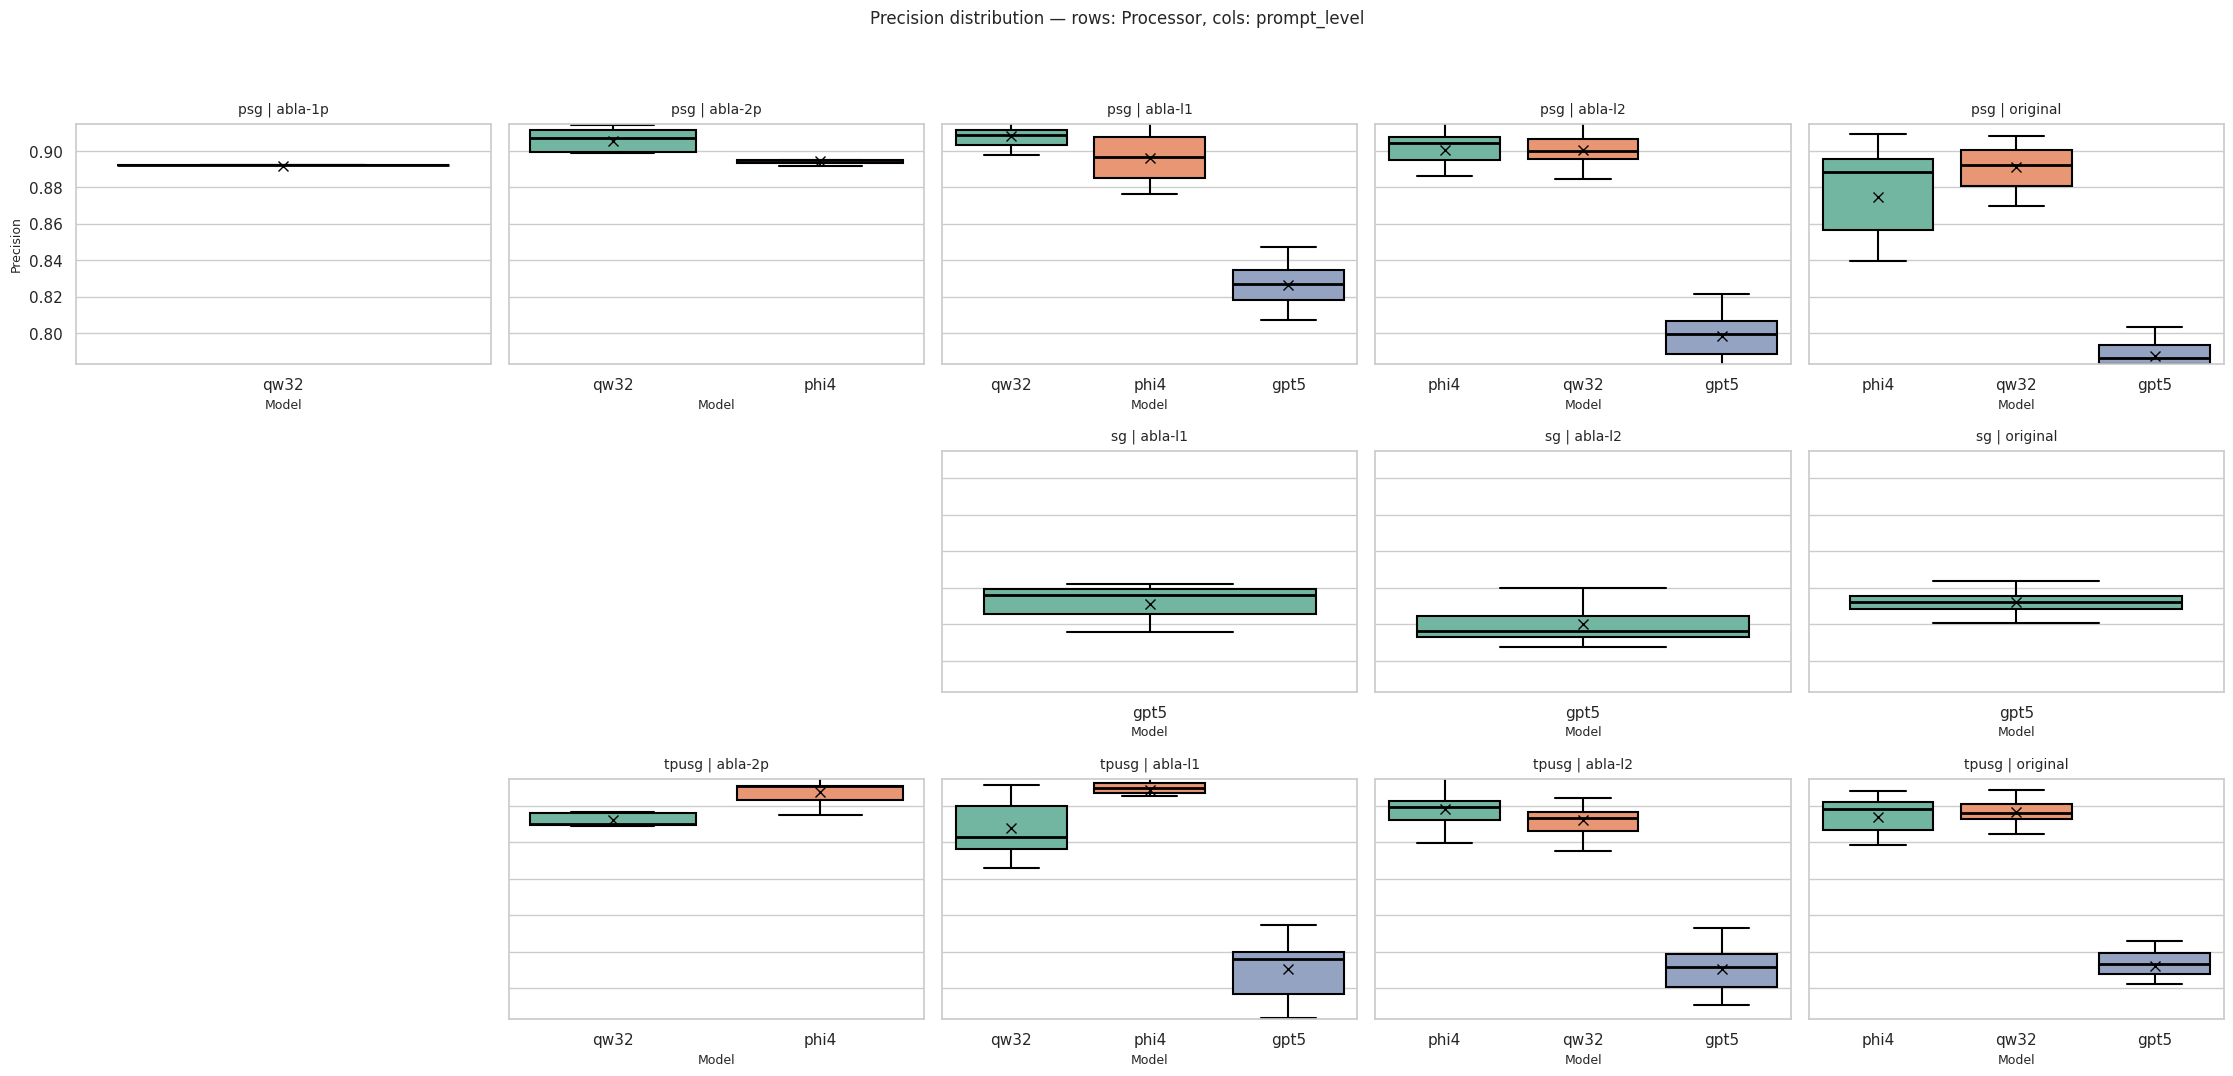

/tmp/ipykernel_3439094/993431529.py:29: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_3439094/993431529.py:29: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_3439094/993431529.py:29: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_3439094/993431529.py:29: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_3439094/993431529.py:29: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_3439094/993431529.py:29: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_3439094/993431529.py:29: UserWarning: The palette list has more values (8) than needed (1),

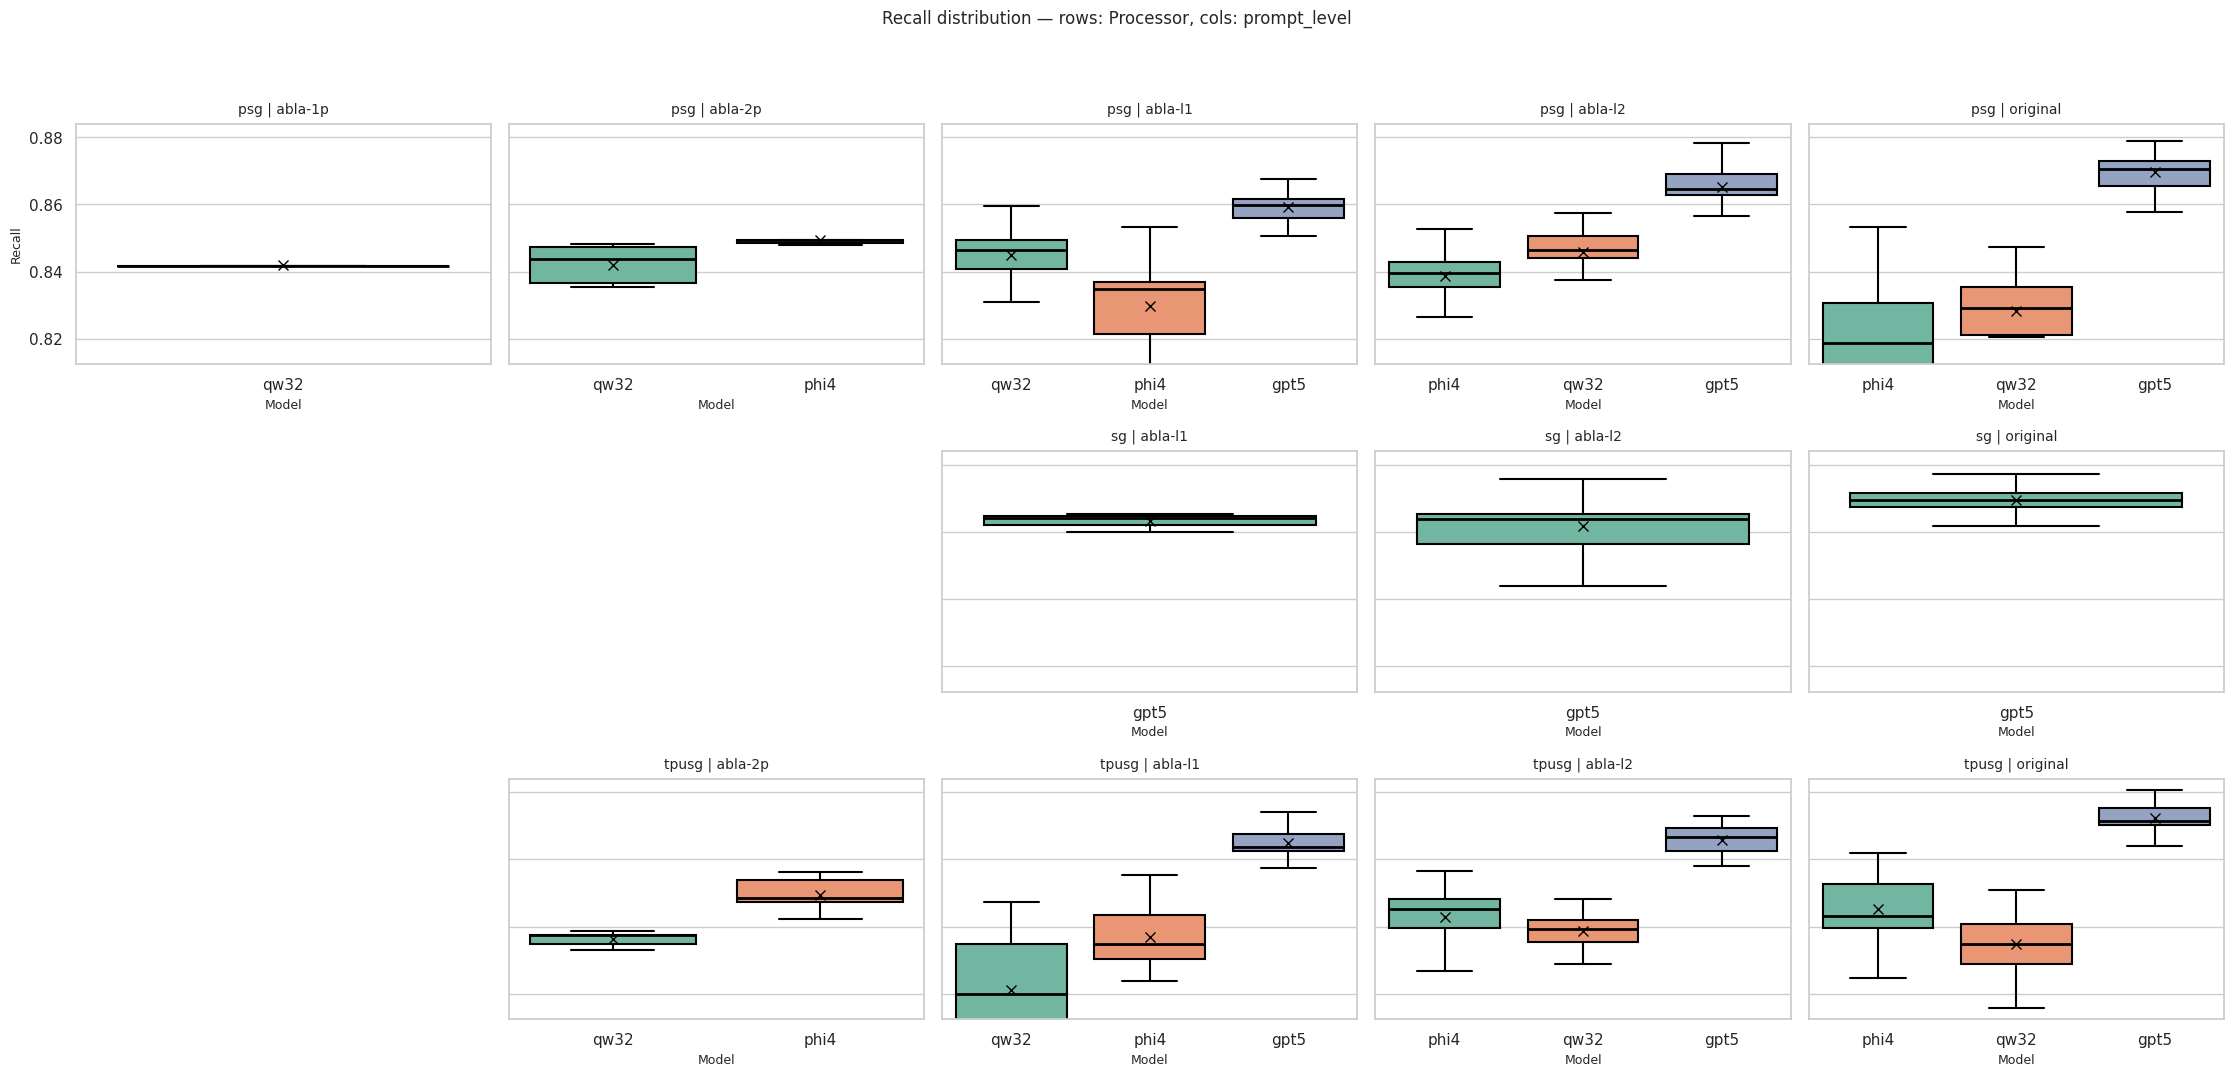

/tmp/ipykernel_3439094/993431529.py:29: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_3439094/993431529.py:29: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_3439094/993431529.py:29: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_3439094/993431529.py:29: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_3439094/993431529.py:29: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_3439094/993431529.py:29: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_3439094/993431529.py:29: UserWarning: The palette list has more values (8) than needed (1),

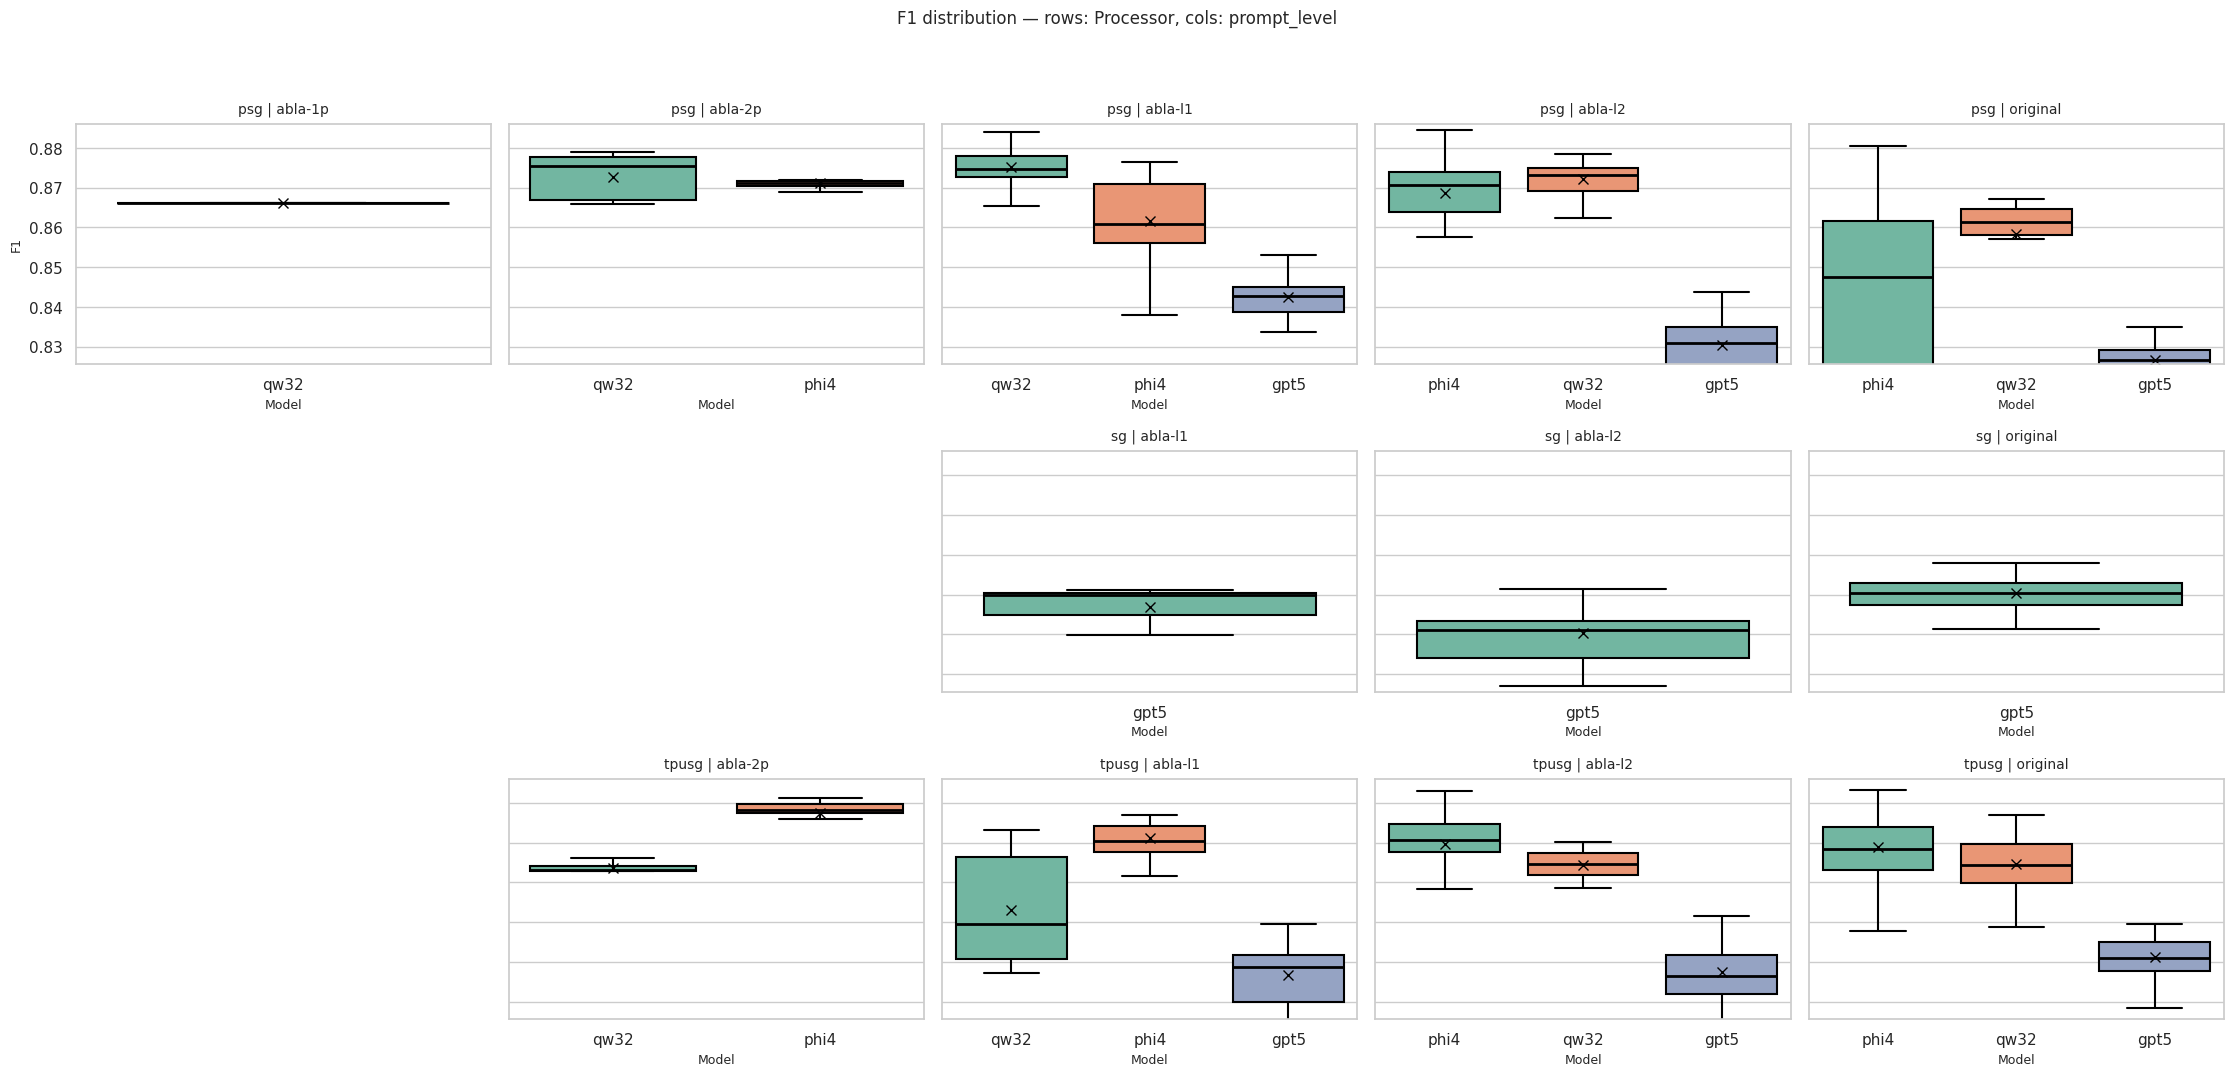

/tmp/ipykernel_3439094/993431529.py:29: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_3439094/993431529.py:29: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_3439094/993431529.py:29: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_3439094/993431529.py:29: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_3439094/993431529.py:29: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_3439094/993431529.py:29: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_3439094/993431529.py:29: UserWarning: The palette list has more values (8) than needed (1),

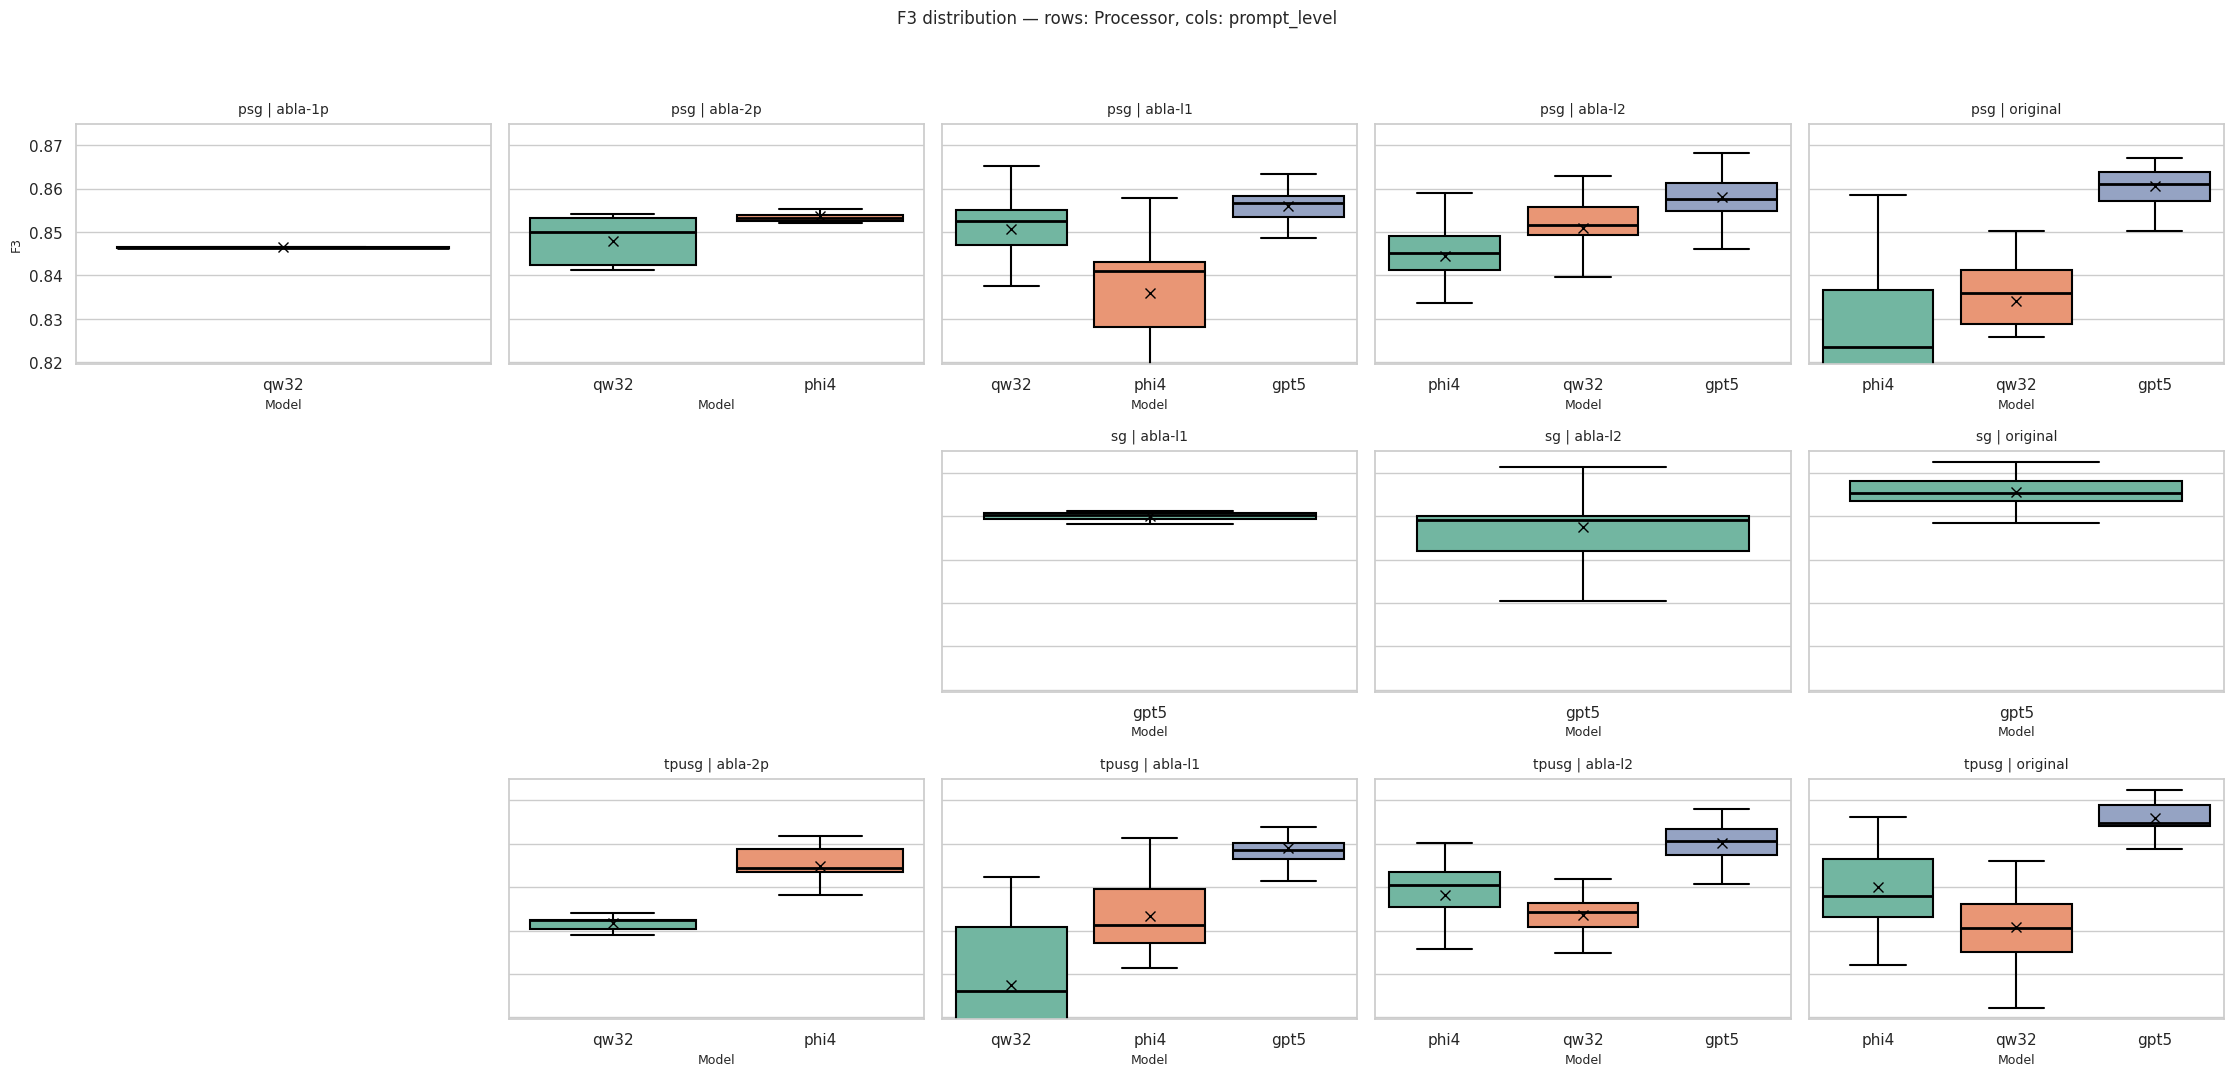

In [41]:
from matplotlib.lines import Line2D

if df.empty:
    print("No data to plot.")
else:
    metrics = ["Precision", "Recall", "F1", "F3"]
    processors = sorted(df["Processor"].unique())
    prompts = sorted(df["Prompt_level"].unique())

    for metric in metrics:
        fig, axes = plt.subplots(
            nrows=len(processors),
            ncols=len(prompts),
            figsize=(len(prompts) * 4.5, len(processors) * 3.6),
            sharey=True,
        )
        axes = np.array(axes).reshape(len(processors), len(prompts))

        legend_handles = None
        legend_labels = None

        for i, proc in enumerate(processors):
            for j, prompt in enumerate(prompts):
                ax = axes[i, j]
                subset = df[(df["Processor"] == proc) & (df["Prompt_level"] == prompt)]
                if subset.empty:
                    ax.set_visible(False)
                    continue
                sns.boxplot(
                    data=subset,
                    x="Model",
                    y=metric,
                    hue="Model",
                    palette=COLOR_PALETTE,
                    ax=ax,
                    **BOX_KWARGS,
                )
                ax.set_title(f"{proc} | {prompt}", fontsize=10, pad=8)
                ax.set_xlabel("Model", fontsize=9)
                ax.set_ylabel(metric if j == 0 else "", fontsize=9)
                # Set y-axis limits based on data range in this subplot
                y_min, y_max = subset[metric].min(), subset[metric].max()
                y_range = y_max - y_min
                ax.set_ylim(max(0, y_min - 0.05 * y_range), min(1, y_max + 0.05 * y_range))
                # Capture legend handles/labels once
                if legend_handles is None and ax.get_legend():
                    legend_handles, legend_labels = ax.get_legend_handles_labels()
                if ax.get_legend():
                    ax.legend_.remove()

        if legend_handles:
            fig.legend(legend_handles, legend_labels, title="Model", loc="upper center", 
                      ncol=len(legend_labels), fontsize=9, bbox_to_anchor=(0.5, 1.0))
        fig.suptitle(f"{metric} distribution — rows: Processor, cols: prompt_level", 
                    fontsize=12, y=0.995)
        fig.tight_layout(rect=[0, 0, 1, 0.96])

        plt.show()

## Coverage and counts by prompt_level and processor

In [42]:
if df.empty:
    print("No data available.")
else:
    counts = df.groupby(["Prompt_level", "Processor", "Model"]).size().reset_index(name="rows")
    counts_pivot = counts.pivot_table(values="rows", index=["Prompt_level", "Processor"], columns="Model", fill_value=0)
    display(counts)
    display(counts_pivot)

,Prompt_level,Processor,Model,rows
0,abla-1p,psg,qw32,12
1,abla-2p,psg,phi4,17
2,abla-2p,psg,qw32,30
3,abla-2p,tpusg,phi4,48
4,abla-2p,tpusg,qw32,30
5,abla-l1,psg,gpt5,30
6,abla-l1,psg,phi4,15
7,abla-l1,psg,qw32,24
8,abla-l1,sg,gpt5,3
9,abla-l1,tpusg,gpt5,30


Model                   gpt5  phi4  qw32
Prompt_level Processor                  
abla-1p      psg         0.0   0.0  12.0
abla-2p      psg         0.0  17.0  30.0
             tpusg       0.0  48.0  30.0
abla-l1      psg        30.0  15.0  24.0
             sg          3.0   0.0   0.0
             tpusg      30.0  12.0  24.0
abla-l2      psg        30.0  28.0  25.0
             sg         21.0   0.0   0.0
             tpusg      30.0  27.0  18.0
original     psg        29.0  18.0  18.0
             sg         30.0   0.0   0.0
             tpusg      27.0  30.0  30.0

## Top performers within each prompt_level and processor

In [43]:
if df.empty:
    print("No data available.")
else:
    top = (
        df.sort_values("F1", ascending=False)
        .groupby(["Prompt_level", "Processor", "Model"])
        .head(3)
    )
    top[["Prompt_level", "Processor", "Model", "Candidate_ID", "F1", "Precision", "Recall", "F3"]]

## Metric distributions by prompt_level

/tmp/ipykernel_3439094/1376194237.py:7: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(data=df, x="Prompt_level", y=metric, hue="Processor", ax=ax, palette=COLOR_PALETTE, **BOX_KWARGS)
/tmp/ipykernel_3439094/1376194237.py:7: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(data=df, x="Prompt_level", y=metric, hue="Processor", ax=ax, palette=COLOR_PALETTE, **BOX_KWARGS)
/tmp/ipykernel_3439094/1376194237.py:7: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(data=df, x="Prompt_level", y=metric, hue="Processor", ax=ax, palette=COLOR_PALETTE, **BOX_KWARGS)
/tmp/ipykernel_3439094/1376194237.py:7: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(data=df, x="Prompt_level", y=metric, hue="Processor", ax=ax, palette=COLOR_PALETTE, **BOX_KWARGS)


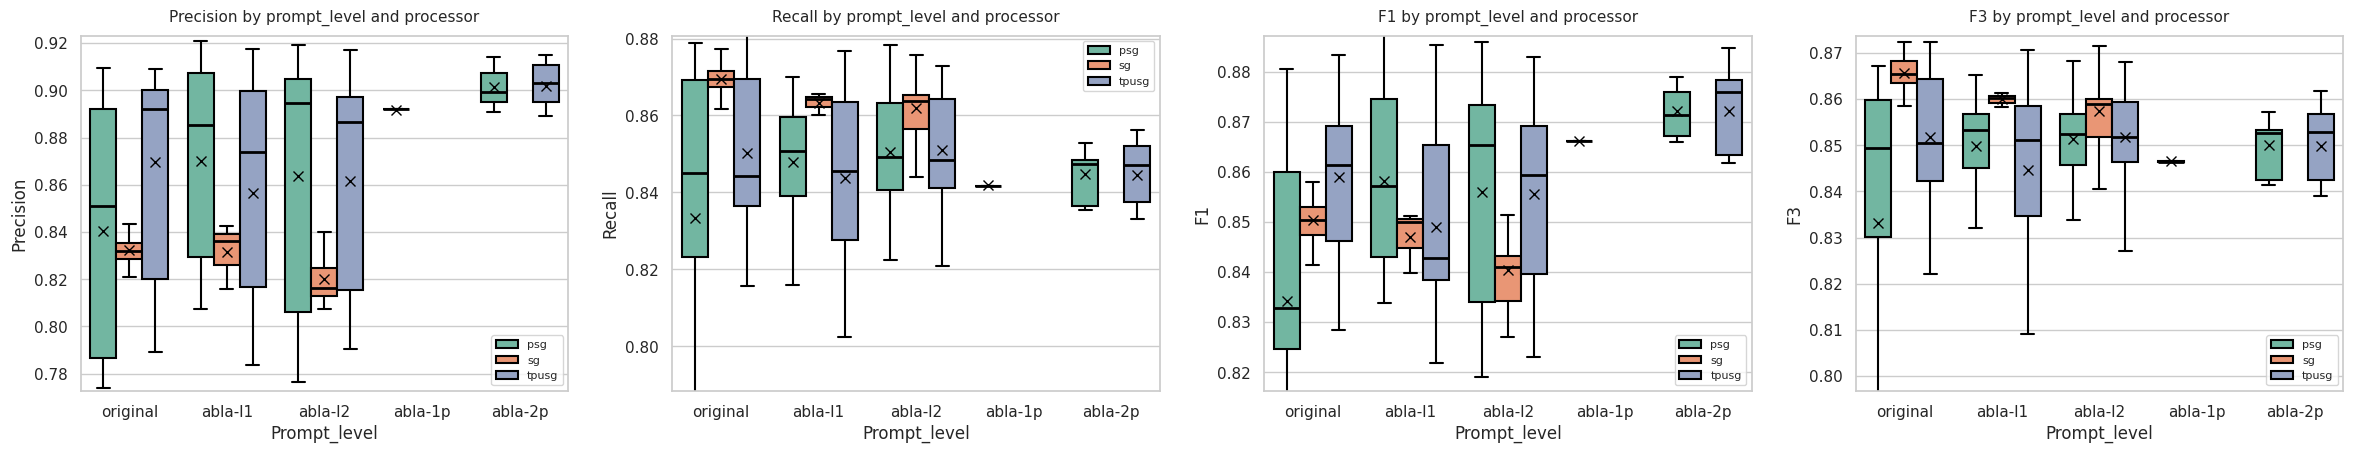

In [44]:
if df.empty:
    print("No data to plot.")
else:
    metrics = ["Precision", "Recall", "F1", "F3"]
    fig, axes = plt.subplots(1, 4, figsize=(24, 5))
    for ax, metric in zip(axes.flat, metrics):
        sns.boxplot(data=df, x="Prompt_level", y=metric, hue="Processor", ax=ax, palette=COLOR_PALETTE, **BOX_KWARGS)
        ax.set_title(f"{metric} by prompt_level and processor", fontsize=11, pad=10)
        # Set y-axis limits based on data range for this metric
        y_min, y_max = df[metric].quantile([0.01, 0.99])  # Use 1st and 99th percentile
        y_range = y_max - y_min
        ax.set_ylim(max(0, y_min - 0.05 * y_range), min(1, y_max + 0.05 * y_range))
        ax.legend(loc="best", fontsize=8)

    plt.tight_layout(pad=2.0)
    plt.show()

/tmp/ipykernel_3439094/3020993432.py:7: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  g = sns.catplot(


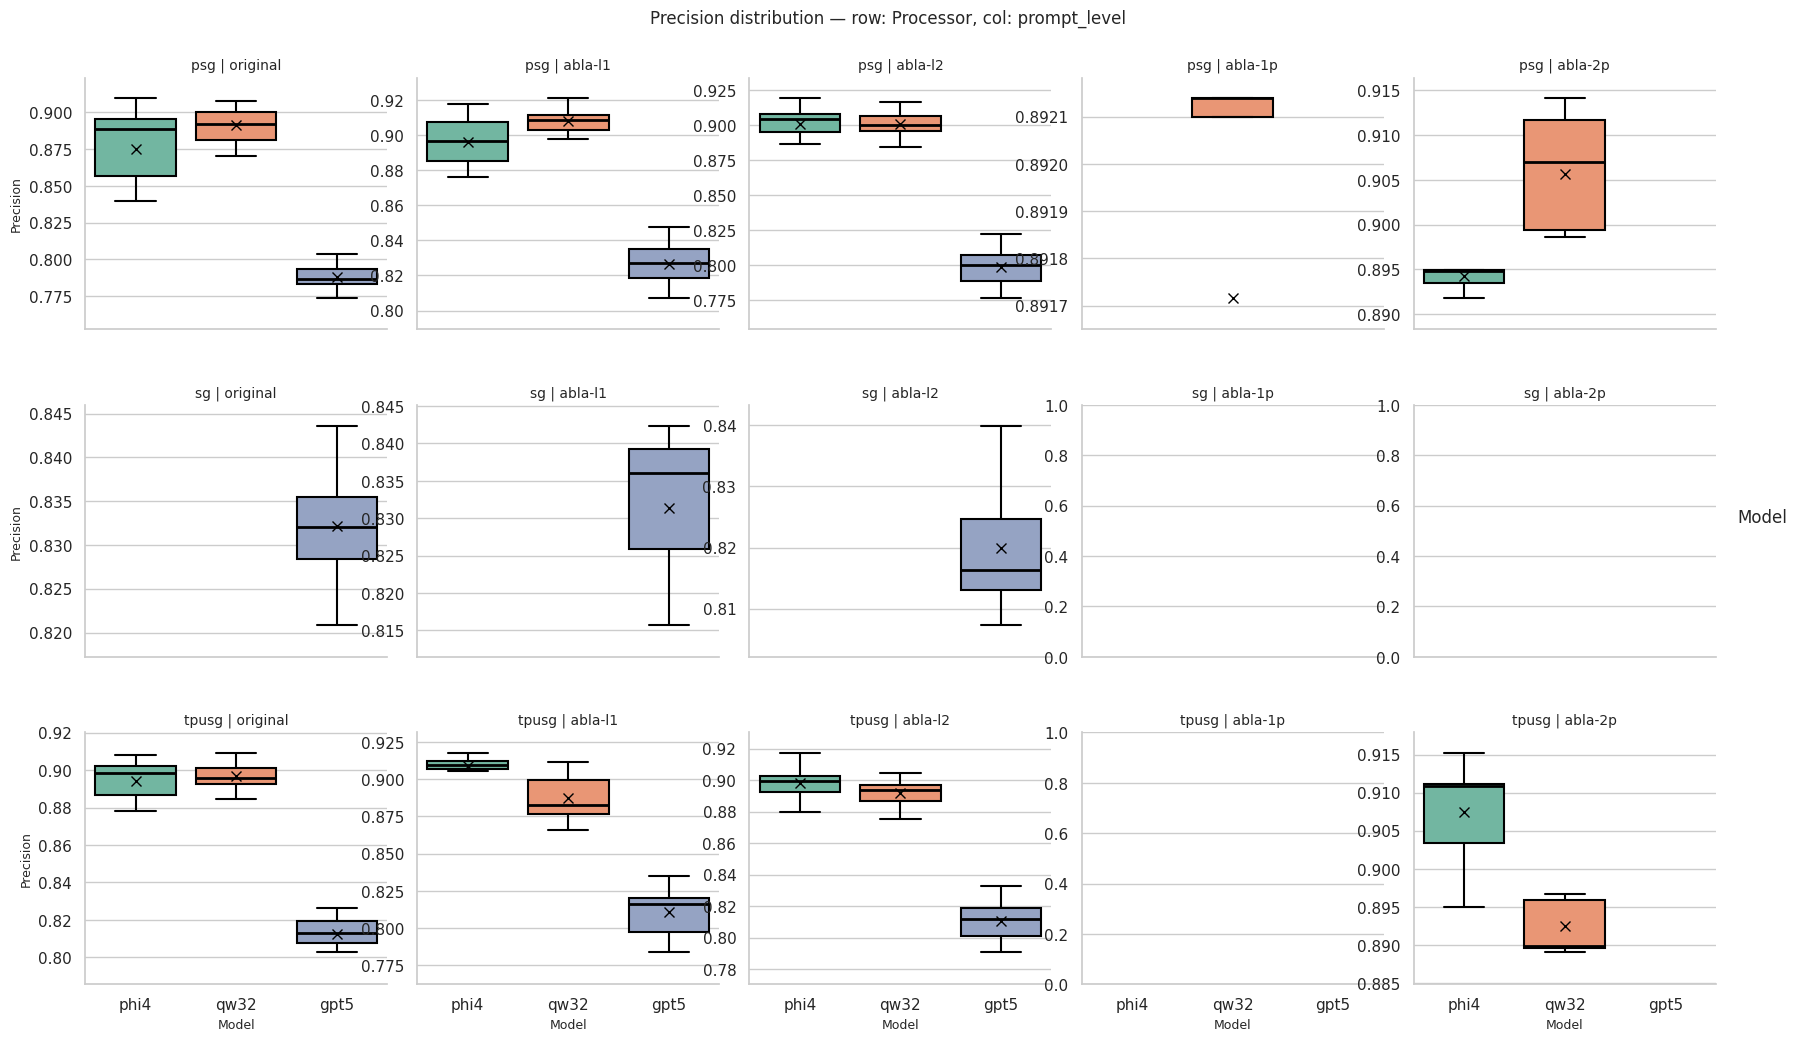

/tmp/ipykernel_3439094/3020993432.py:7: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  g = sns.catplot(


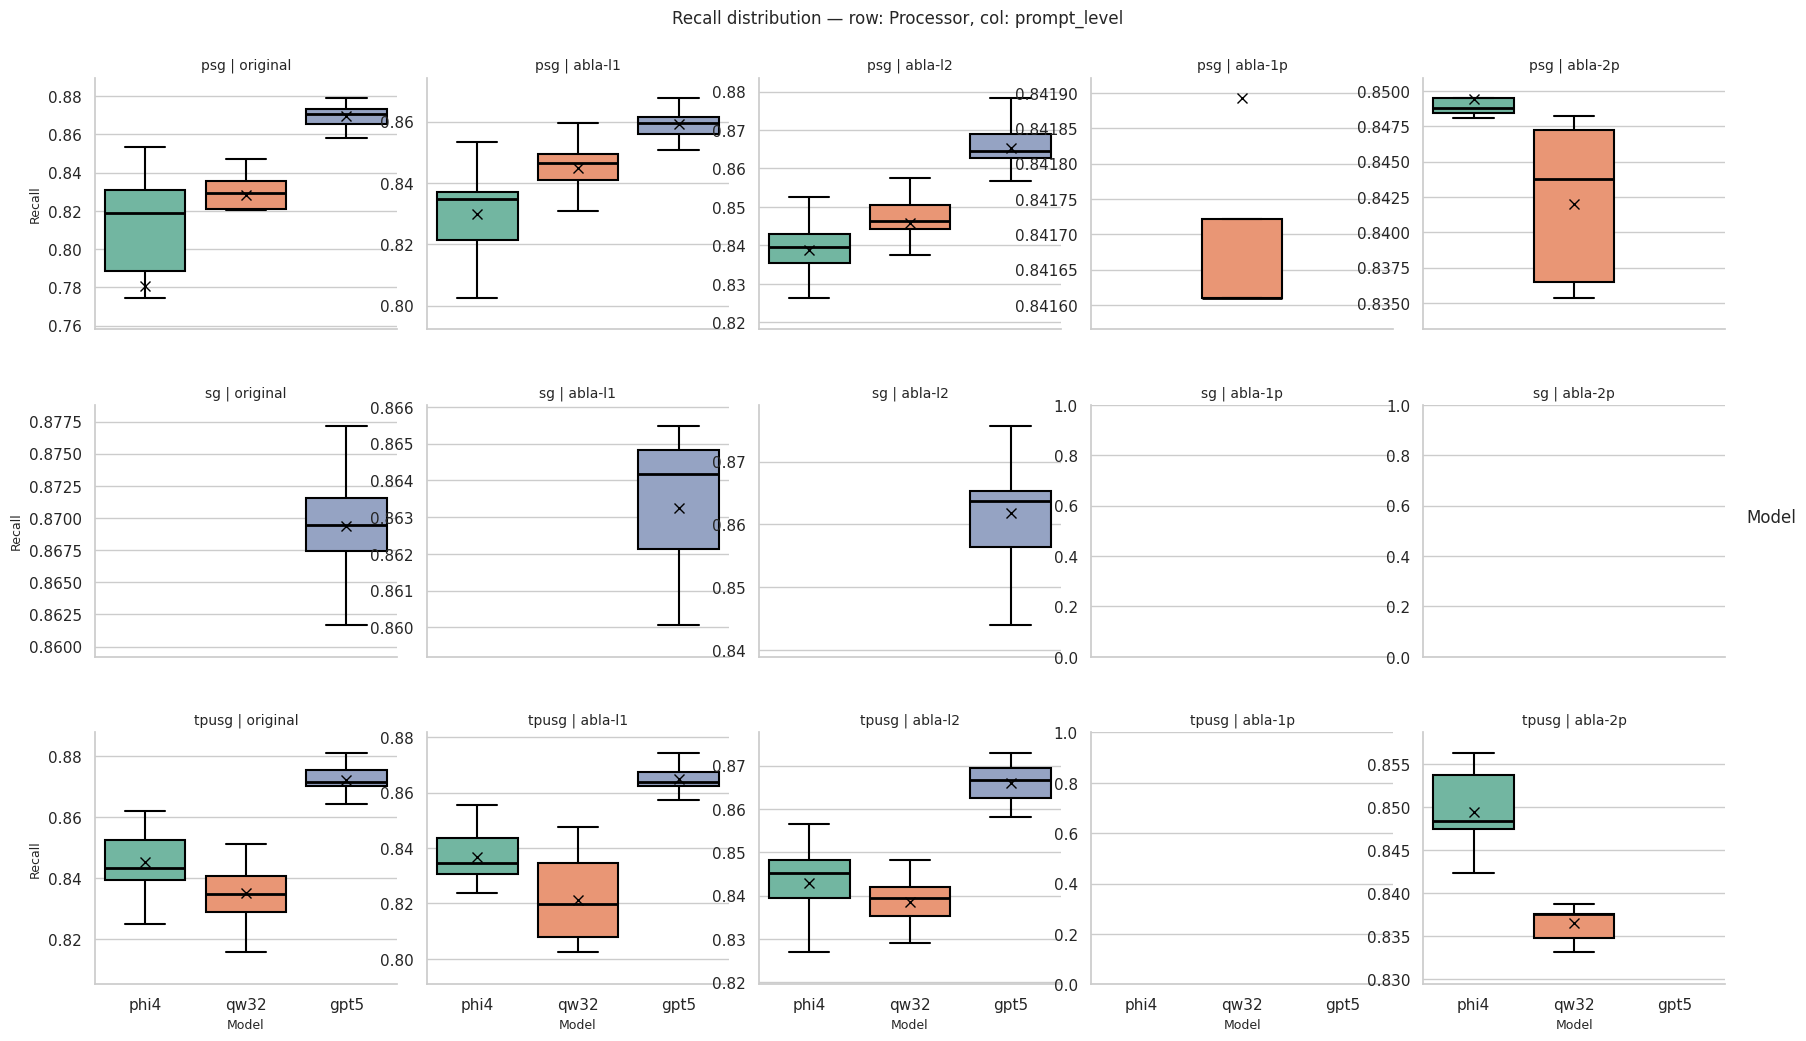

/tmp/ipykernel_3439094/3020993432.py:7: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  g = sns.catplot(


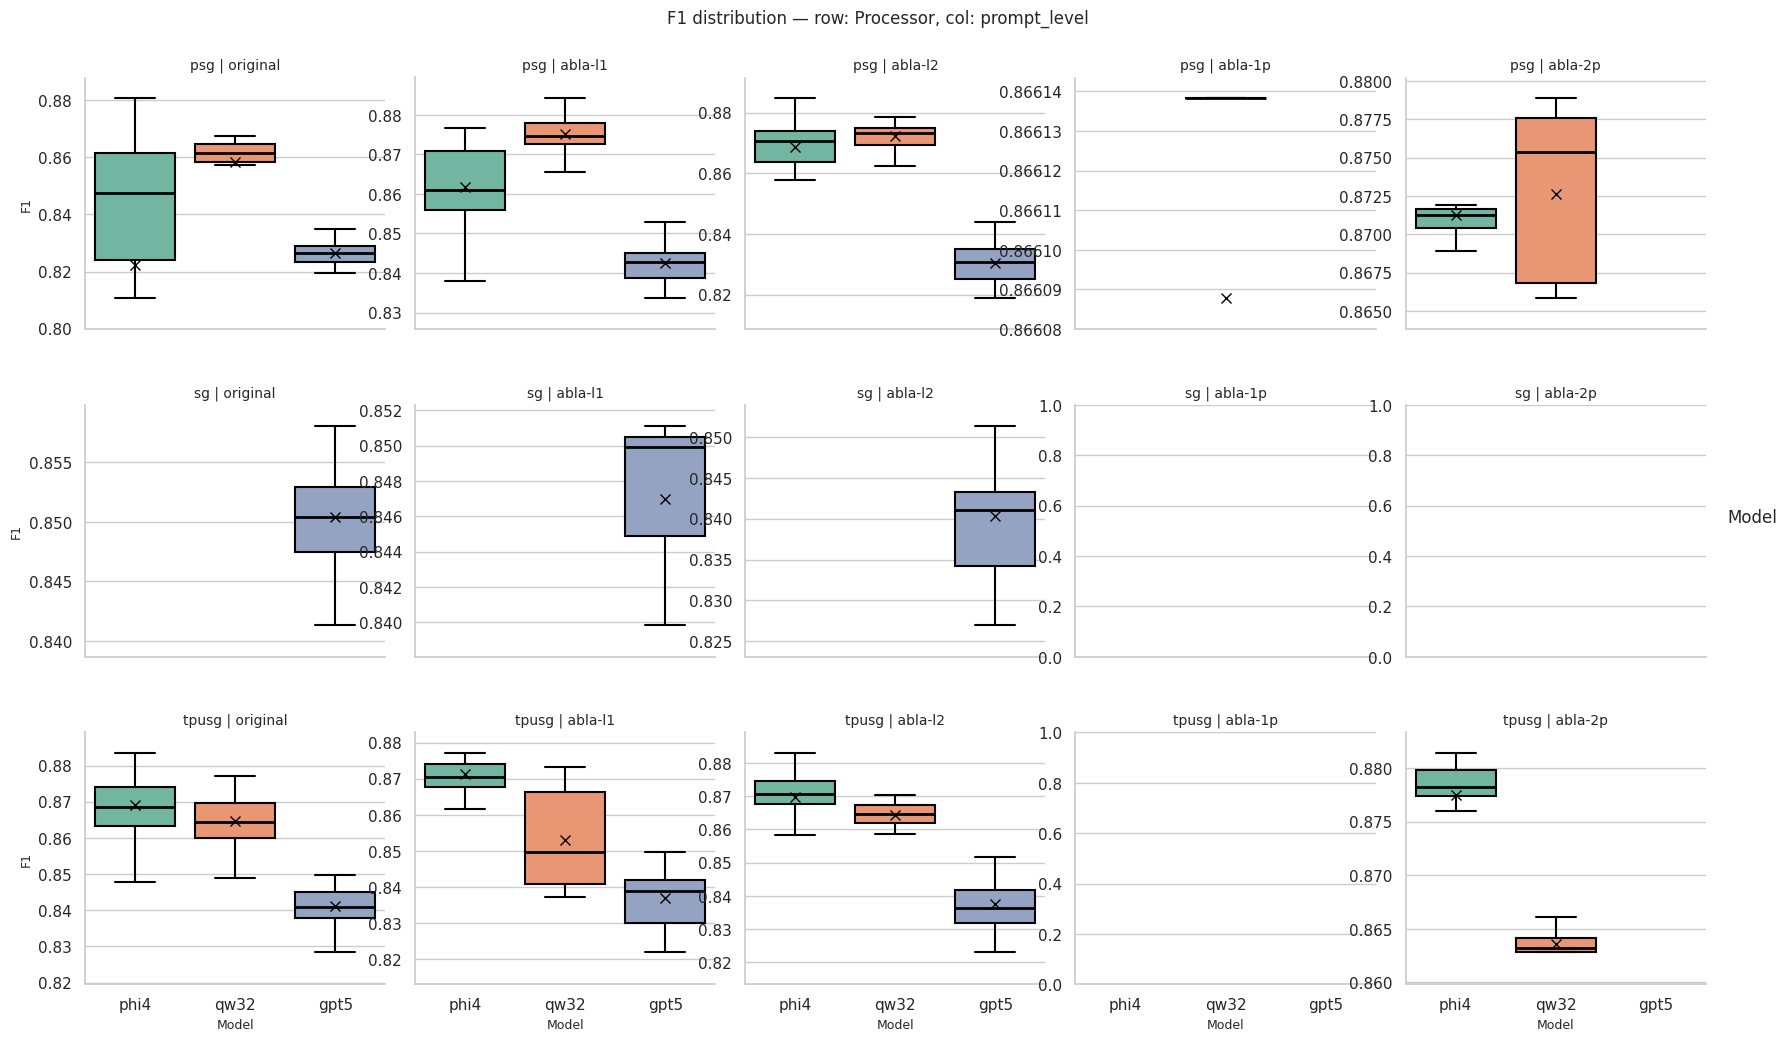

/tmp/ipykernel_3439094/3020993432.py:7: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  g = sns.catplot(


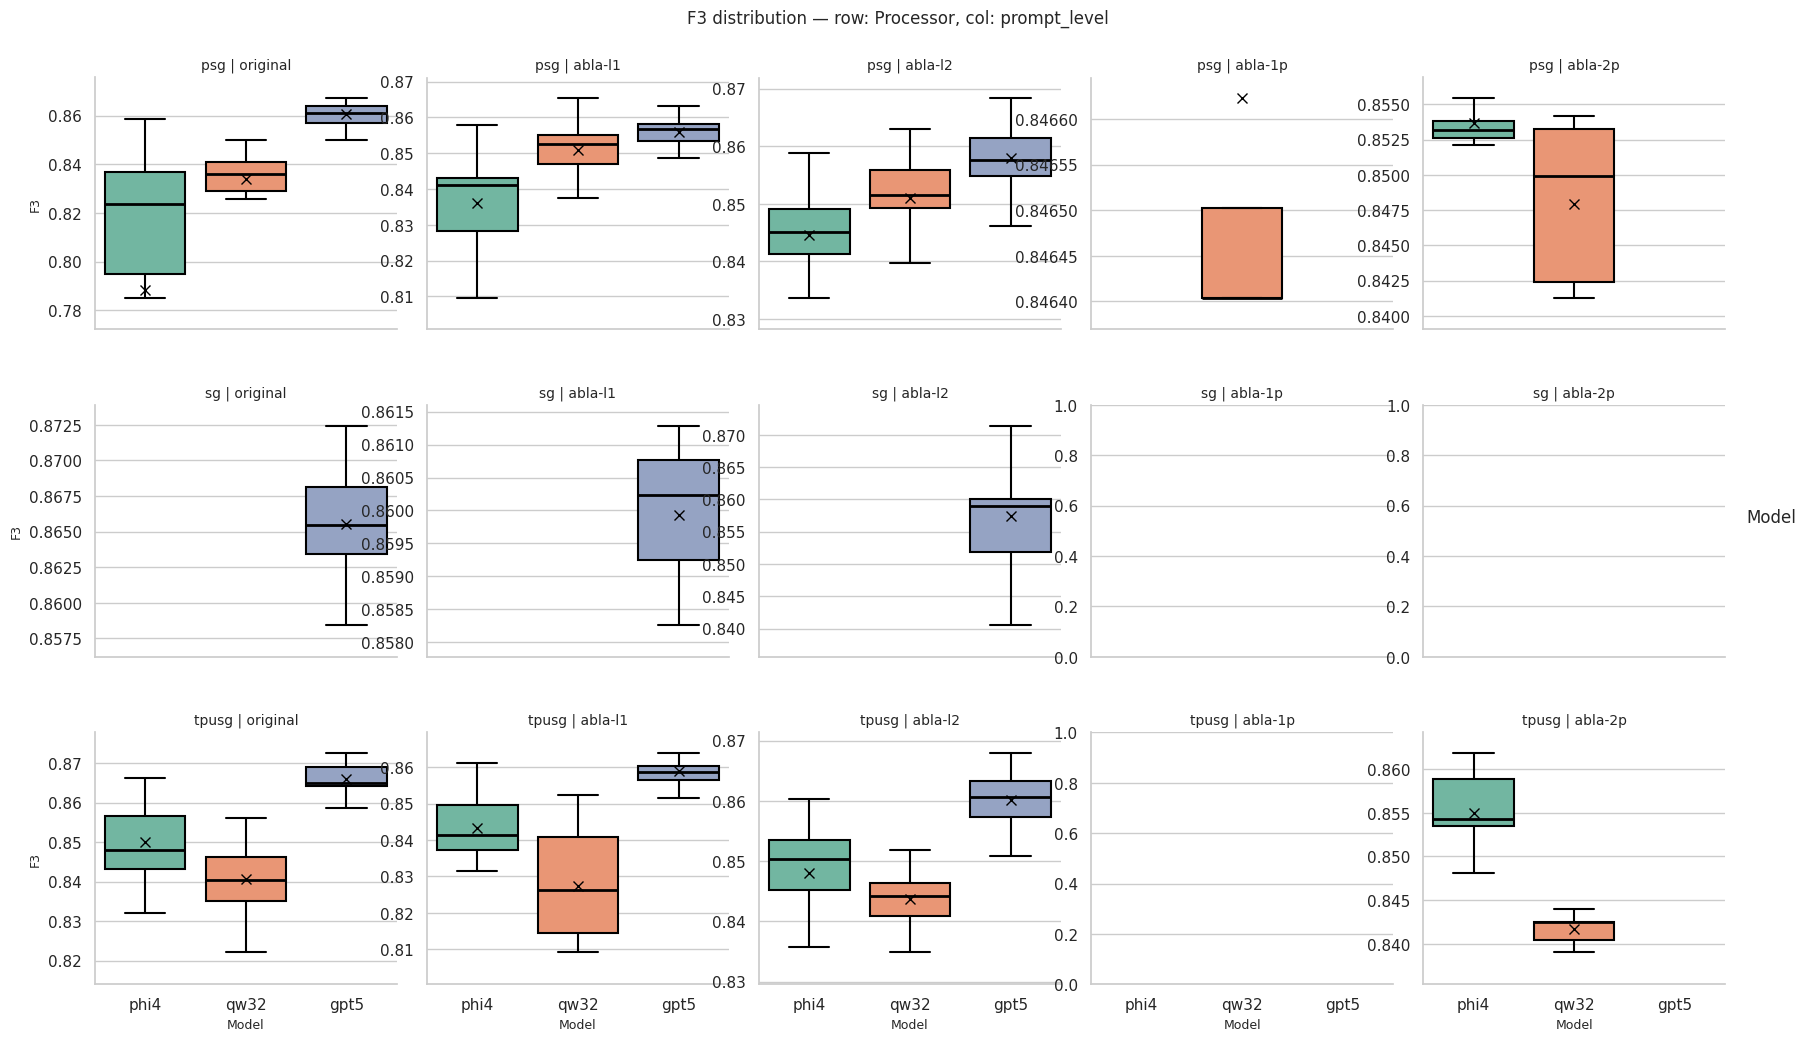

In [45]:
# 3x3 grid per metric: rows = Processor, cols = prompt_level, hue = Model
if df.empty:
    print("No data to plot.")
else:
    metrics = ["Precision", "Recall", "F1", "F3"]
    for metric in metrics:
        g = sns.catplot(
            data=df,
            x="Model",
            y=metric,
            hue="Model",
            row="Processor",
            col="Prompt_level",
            kind="box",
            sharey=False,  # Allow independent y-axes per subplot
            height=3.5,
            aspect=1.0,
            palette=COLOR_PALETTE,
            **BOX_KWARGS,
        )
        # Add some padding to each subplot's y-axis
        for ax in g.axes.flat:
            if ax.has_data():
                y_min, y_max = ax.get_ylim()
                y_range = y_max - y_min
                # Add 10% padding on top and bottom
                ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.05 * y_range)

        # Adjust title sizes for catplot facets
        g.set_titles("{row_name} | {col_name}", size=10)
        g.set_axis_labels("Model", metric, fontsize=9)
        
        # Apply layout adjustments BEFORE showing
        g.fig.subplots_adjust(top=0.93, hspace=0.3, wspace=0.1)
        g.add_legend(title="Model", fontsize=8)
        g.fig.suptitle(f"{metric} distribution — row: Processor, col: prompt_level", 
                      fontsize=12, y=0.995)
        
        plt.show()